# Array Response Function (ARF) for Different Array Configurations & Frequencies

In the exercise, we are going to check the ARF of three different arrays with square, cross and circular configurations. We will try both delta and sine functions as input signals. Dirac delta function has the same amplitude for all frequencies in the frequency spectrum, and for the sine wave function with specific frequency.
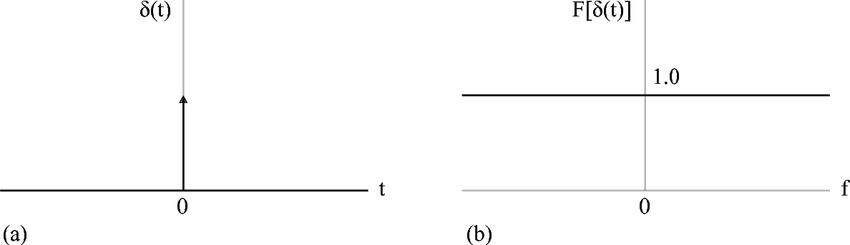
Figure. (a) Dirac delta function in the time domain. (b) Frequency spectrum of the Dirac delta function.

In [2]:
#import the required modules and functions
from pydsm.relab import shiftdim
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client 
from obspy import UTCDateTime

In [3]:
# Execute cell above twice
shiftdim?

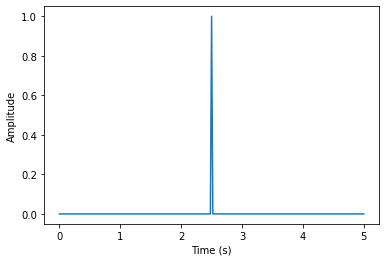

In [4]:
## generate a delta function, and assume the point source is right beneth the array,   
## so the plane wave arrives simultaneously through
dltf = np.zeros((251,1))
##add amplitude 1 to the middle of the signal
dltf[125] = 1
##set the data sample interval in seconds
recSampInt = 0.02
recNumData = len(dltf)
##assign time to the signal, 5s signal
xtim = np.arange(0,recNumData*recSampInt-recSampInt,recSampInt)

plt.plot(xtim,dltf)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

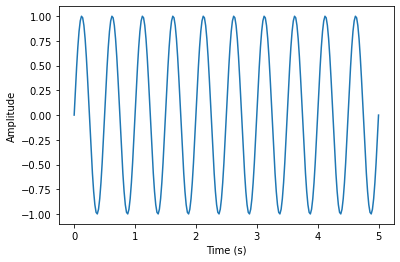

In [5]:
## generate a sine function, and assume the point source is right 
## beneth the array, so the plane wave arrives simultaneously through 

freq= 2 #frequnecy in Hz
sinf = np.sin(2*np.pi*freq*xtim)
##add amplitude 1 to the middle of the signal

plt.plot(xtim,sinf)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [7]:
## Preparing data
dt = recSampInt  # sampling interval
Fmax = 1/dt; # maximum frequency
Nfft = recNumData # number of samples in each chopped seismogram (i.e. number in fft)
#frq = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)) #central frequencies
frq = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int64(Nfft/2+1)) #central frequencies

## 1. ARF of a cross shape array with two linear arrays. 
### Tasks:
1) ARF with a delta function <br>
2) ARF with a sine wave function at frequency 1 Hz <br>
3) ARF with a sine wave function, varying the freqeuncy <br>
4) ARF with a sine wave function, change the array size 

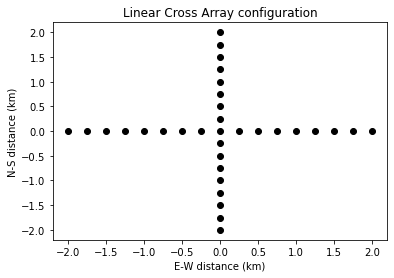

In [8]:
## load array locations
##cross linear array, with coordinates in x-y
array_linear_cross = np.loadtxt("./array_linear_cross.txt") 
##select data function "dltf" or "sinf"
freq= 2 #frequnecy in Hz
sinf = np.sin(2*np.pi*freq*xtim)

data_test = dltf #dltf #sinf 

##change the size of the array
array_size_factor=100 # changes how large array is - changes ARF

array_linear_cross /= array_size_factor
plt.plot(array_linear_cross[:,0],array_linear_cross[:,1],'ko')
plt.xlabel('E-W distance (km)')
plt.ylabel('N-S distance (km)')
plt.title('Linear Cross Array configuration')
plt.show()

acent=[np.mean(array_linear_cross[:,0]), np.mean(array_linear_cross[:,1])] #array center
##distance of each station to the array center
distE = array_linear_cross[:,0] - acent[0] # NS offset in km
distN = array_linear_cross[:,1] - acent[1] # EW offset in km

In [9]:
## Calculate the ARF in slowness domain
## Slowness domain
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;
beam=np.zeros([len(NsloV),len(EsloV)])

vehlp = np.fft.fft(data_test) # Discrete Fourier transform of the input signal
for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = data_test*0
        for ind3 in np.arange(array_linear_cross.shape[0]):
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag/ time delay from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1) #shift in frequency domain
            dshft = rep.T*shft 
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))  # back to time domain
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
        beam[ind1,ind2] = np.sum((stdel/array_linear_cross.shape[0])**2)

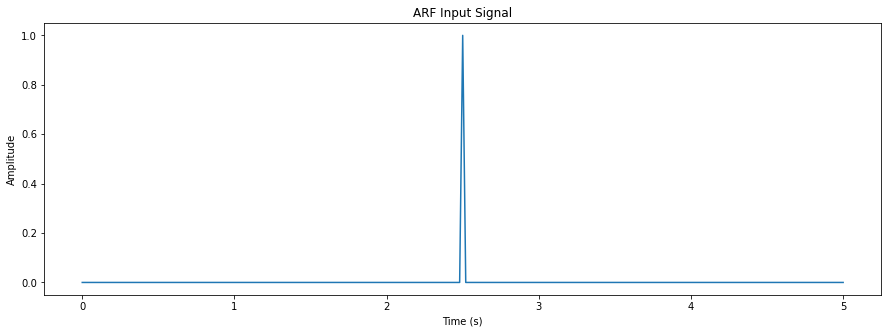

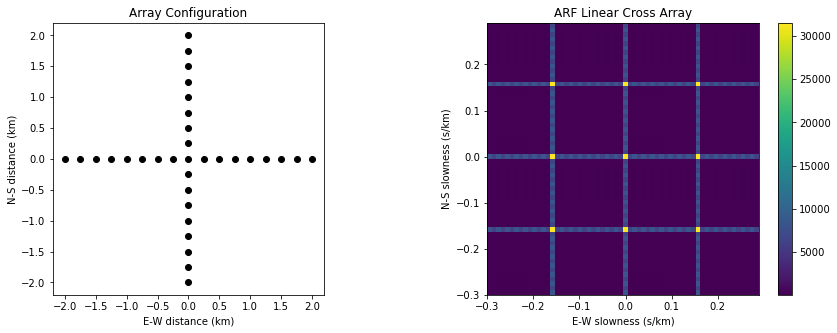

In [10]:
##plot the input signal, array configuration and the corresponding ARF
plt.figure(figsize=(15,5))
plt.plot(xtim,data_test)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ARF Input Signal')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(array_linear_cross[:,0],array_linear_cross[:,1],'ko')
ax1.set_xlabel('E-W distance (km)')
ax1.set_ylabel('N-S distance (km)')
ax1.set_title('Array Configuration')
aspectratio = 1.0
ratio_default=(ax1.get_xlim()[1]-ax1.get_xlim()[0])/(ax1.get_ylim()[1]-ax1.get_ylim()[0])
ax1.set_aspect(ratio_default*aspectratio)

bm = ax2.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax2.set_aspect(aspectratio)
ax2.set_xlabel('E-W slowness (s/km)')
ax2.set_ylabel('N-S slowness (s/km)')
ax2.set_title('ARF Linear Cross Array')
plt.colorbar(bm, ax=ax2)

1) ARF with a delta function

- Distinct lines

2) ARF with a sine wave function at frequency 1 Hz

- Smoother

3) ARF with a sine wave function, varying the frequency

- Higher frequency, more defined/ straight lines.
- With increasing frequency the fokus of the main lobe increases.
- But if f too high --> coherence of singal will become worse and side lobes will become stronger.

4) ARF with a sine wave function, change the array size 

- Smaller array size, lower resolution


Using higher frequencies and larger arrays we get better solution for the beams.

## 2. ARF of a square configuration array

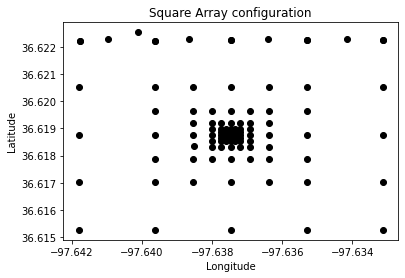

In [11]:
##load the Oklahoma array which is designed to monitor induced seismicity
##rember to change the directory path
array_ok = np.loadtxt("./array_ok.txt")
plt.plot(array_ok[:,0],array_ok[:,1],'ko')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Square Array configuration')
plt.show()
acent=[np.mean(array_ok[:,0]), np.mean(array_ok[:,1])] #array center

##distance of each station to the array center, lat-lon to x-y in km
distN = (array_ok[:,1] - acent[1])*111.0; # NS offset in km
distE = (array_ok[:,0] - acent[0])*111.0*np.cos(acent[1]/180*np.pi) ## cos(acent(2)*pi/180); % EW offset in km

**Note: usually circular array has better ARF**

Different station intervals: capture large frequency ranges

In [12]:
##select data function "dltf" or "sinf"
freq= 2 #frequnecy in Hz
sinf = np.sin(2*np.pi*freq*xtim)


data_test = dltf #dltf #sinf 


vehlp = np.fft.fft(data_test) # Discrete Fourier transform of the input signal
## Slowness domain
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;
beam=np.zeros([len(NsloV),len(EsloV)])

for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = data_test*0
        for ind3 in np.arange(array_ok.shape[0]):
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1)
            dshft = rep.T*shft
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
        beam[ind1,ind2] = np.sum((stdel/len(dltf))**2)

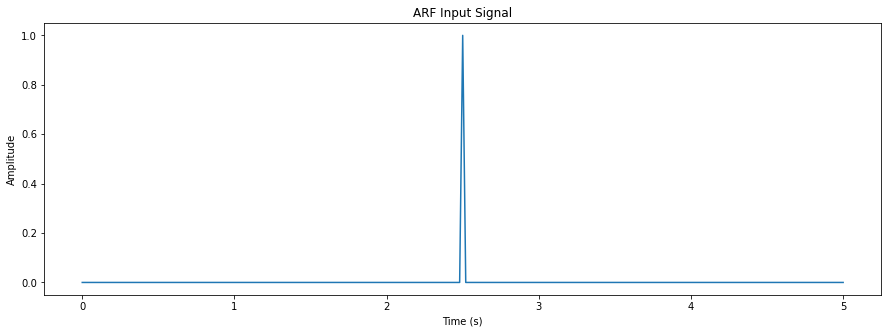

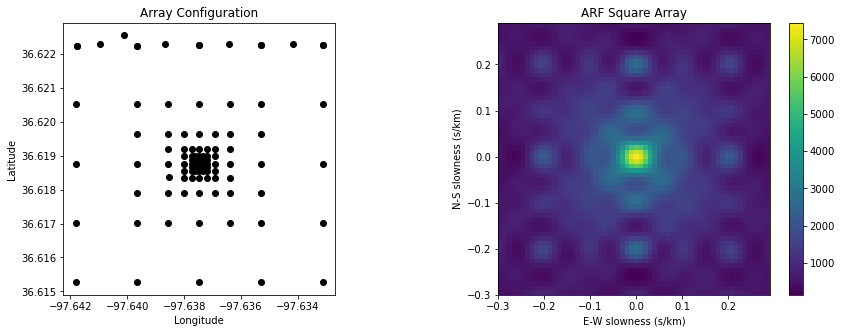

In [13]:
##plot the input signal, array configuration and the corresponding ARF
plt.figure(figsize=(15,5))
plt.plot(xtim,data_test)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ARF Input Signal')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(array_ok[:,0],array_ok[:,1],'ko')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Array Configuration')
aspectratio = 1.0
ratio_default=(ax1.get_xlim()[1]-ax1.get_xlim()[0])/(ax1.get_ylim()[1]-ax1.get_ylim()[0])
ax1.set_aspect(ratio_default*aspectratio)

bm = ax2.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax2.set_aspect(aspectratio)
ax2.set_xlabel('E-W slowness (s/km)')
ax2.set_ylabel('N-S slowness (s/km)')
ax2.set_title('ARF Square Array')
plt.colorbar(bm, ax=ax2)

Use array which can resolve frequencies you are interested in!

With sin fkt instead of delta:

Using higher frequencies:
- becomes closer to delta fkt
- keep aliasing in mind

## 3. ARF of a circular configuration array

In [15]:
#from cartopy import *

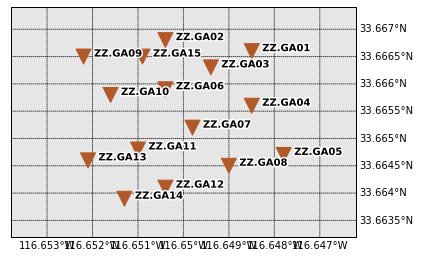

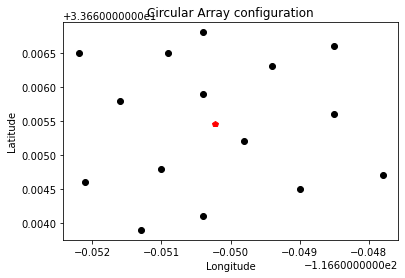

In [16]:
##GA array in southern CA
c = Client("IRIS")

starttime=UTCDateTime("2011-06-06T12:16:00.000")
endtime=UTCDateTime("2011-06-06T12:18:00.000")
inv = c.get_stations(network="ZZ", station="GA*",channel="SHZ",
                                starttime=starttime,
                                endtime=endtime)
#inv.plot()
inv.plot(projection="local")

##get the station locations
station_coordinates=[]
for network in inv:
    for station in network:
        ##station_coordinates.append((network.code, station.code, station.latitude, station.longitude, station.elevation))
        station_coordinates.append(( station.longitude, station.latitude, station.elevation))
#convert the list to array
sta_loc=np.array(station_coordinates) ##print(sta_loc.shape) to check the array size
#sta_loc[:,2]=sta_loc[:,2]/1000 ##convert elevation to km
array_center=[np.mean(sta_loc[:,0]), np.mean(sta_loc[:,1])]
plt.plot(sta_loc[:,0],sta_loc[:,1],'ko')
plt.plot(array_center[0],array_center[1],'rp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Circular Array configuration')
plt.show()

In [17]:
##distance of each station to the array center, lat-lon to x-y in km
distN = (sta_loc[:,1] - array_center[1])*111.0; # NS offset in km
distE = (sta_loc[:,0] - array_center[0])*111.0*np.cos(acent[1]/180*np.pi) ## cos(acent(2)*pi/180); % EW offset in km
##select data function "dltf" or "sinf"
freq= 2 #frequnecy in Hz
sinf = np.sin(2*np.pi*freq*xtim)


data_test = dltf #dltf #sinf 


vehlp = np.fft.fft(data_test) # Discrete Fourier transform of the input signal
## Slowness domain
NsloV = np.arange(-0.3,0.3,0.01);
EsloV = NsloV;
beam=np.zeros([len(NsloV),len(EsloV)])

for ind1 in np.arange(len(EsloV)):
    for ind2 in np.arange(len(NsloV)):
        stdel = data_test*0
        for ind3 in np.arange(sta_loc.shape[0]):
            delay = -1*(distN[ind3]*NsloV[ind1] +  distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
            rep = np.exp(1j*2*np.pi*frq*delay)
            shft = shiftdim(vehlp[0:len(frq)],1,nargout=1)
            dshft = rep.T*shft
            s_sh = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
            stdel = stdel + s_sh/np.max(np.abs(s_sh))
        
        beam[ind1,ind2] = np.sum((stdel/len(dltf))**2)

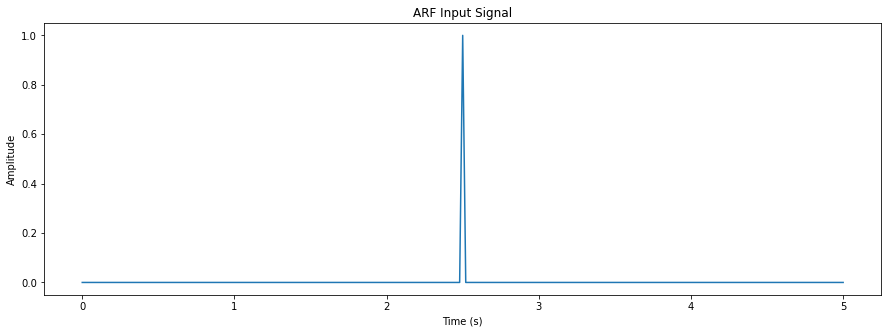

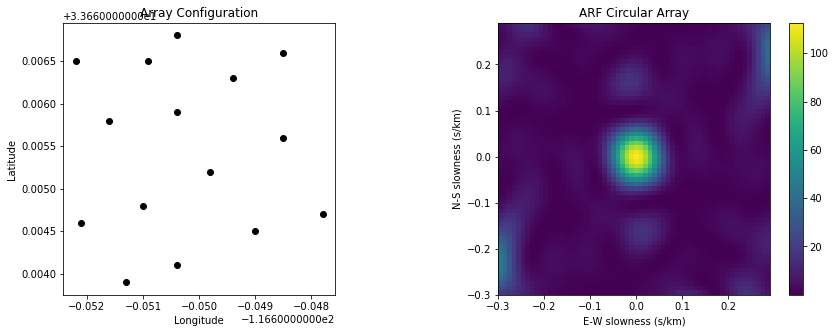

In [18]:
##plot the input signal, array configuration and the corresponding ARF
plt.figure(figsize=(15,5))
plt.plot(xtim,data_test)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ARF Input Signal')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(sta_loc[:,0],sta_loc[:,1],'ko')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Array Configuration')
aspectratio = 1.0
ratio_default=(ax1.get_xlim()[1]-ax1.get_xlim()[0])/(ax1.get_ylim()[1]-ax1.get_ylim()[0])
ax1.set_aspect(ratio_default*aspectratio)

bm = ax2.imshow(beam, aspect='auto', interpolation='none',
           extent=[np.min(EsloV),np.max(EsloV),np.min(NsloV),np.max(NsloV)], origin='lower')
ax2.set_aspect(aspectratio)
ax2.set_xlabel('E-W slowness (s/km)')
ax2.set_ylabel('N-S slowness (s/km)')
ax2.set_title('ARF Circular Array')
plt.colorbar(bm, ax=ax2)